In [163]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data analysis and manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn import tree

# -----------------------------
# Lineal Models
# -----------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

# -----------------------------
# SVMs
# -----------------------------
from sklearn.svm import SVC, LinearSVC

# -----------------------------
# Decision Tree and ensembles
# -----------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

# -----------------------------
# KNN
# -----------------------------
from sklearn.neighbors import KNeighborsClassifier

# -----------------------------
# Naive Bayes
# -----------------------------
from sklearn.naive_bayes import GaussianNB

# -----------------------------
# Neural Network
# -----------------------------
from sklearn.neural_network import MLPClassifier

# -----------------------------
# External Boosters
# -----------------------------
import xgboost as xgb
import lightgbm as lgb

# Loadind dataset
train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv('../input/titanic/test.csv')

# EDA Titanic Dataset

### Variables Qualitatives:
 
* Nominal: Survived, Sex, Embarked, Name, Ticket, Cabin
* Ordinal: Pclass

### Variables Quantitatives:

   * Continuous: Age, Fare
   * Discrete: SibSp, Parch

In [164]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [165]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [166]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Cleaning Dataset

In [167]:
# Some variables with null data that need to be cleaned or filled in
print(f'Train Nulls:\n\n{train_df.isnull().sum()}\n\nTest Nulls:\n\n{test_df.isnull().sum()}')

Train Nulls:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test Nulls:

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [168]:
# Deleting cabin, ticket, name and id variables given the irrelevance for prediction
train_df = train_df.drop(columns=['Cabin', 'Ticket','Name','PassengerId'])
test_df = test_df.drop(columns=['Cabin', 'Ticket','Name'])

In [169]:
# Given most common embarked place to the null data
most_common = train_df['Embarked'].mode()[0]
train_df['Embarked'] = train_df['Embarked'].fillna(most_common)
test_df['Embarked'] = test_df['Embarked'].fillna(most_common)

In [170]:
def impute_variable(row, variable, values_dict, group_cols=('Pclass','Sex')):
    if pd.isnull(row[variable]):
        key = tuple(row[col] for col in group_cols)
        return values_dict.loc[key]
    else:
        return row[variable]
        
# Given the media fare group by pclass and sex for the pclass to the only null fare in test
fare_median = train_df.groupby(['Pclass','Sex'])['Fare'].mean()
test_df['Fare'] = test_df.apply(impute_variable, axis=1, variable='Fare', values_dict=fare_median)

# Given the median age group by pclass and sex to the null ages
age_median = train_df.groupby(['Pclass','Sex'])['Age'].median()
train_df['Age'] = train_df.apply(impute_variable, axis=1, variable='Age', values_dict=age_median)
test_df['Age'] = test_df.apply(impute_variable, axis=1, variable='Age', values_dict=age_median)

print(f'Train Nulls:\n\n{train_df.isnull().sum()}\n\nTest Nulls:\n\n{test_df.isnull().sum()}')

Train Nulls:

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Test Nulls:

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


## Visualizing Dataset

### Number of survivors


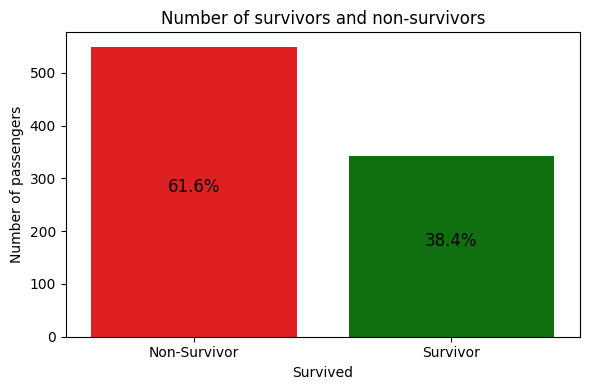

In [171]:
survival_counts = train_df['Survived'].value_counts()
survival_proportion = train_df['Survived'].value_counts(normalize=True)

plt.figure(figsize=(6,4))
sns.barplot(x=survival_counts.index, y=survival_counts.values, palette=['red','green'])
plt.title('Number of survivors and non-survivors')
plt.ylabel('Number of passengers')
plt.xticks([0,1], ['Non-Survivor', 'Survivor'])

for i, value in enumerate(survival_counts.values):
    percentage = survival_proportion[i] * 100
    plt.text(i, value/2, f"{percentage:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

### Total passengers and survivors by sex and their proportion

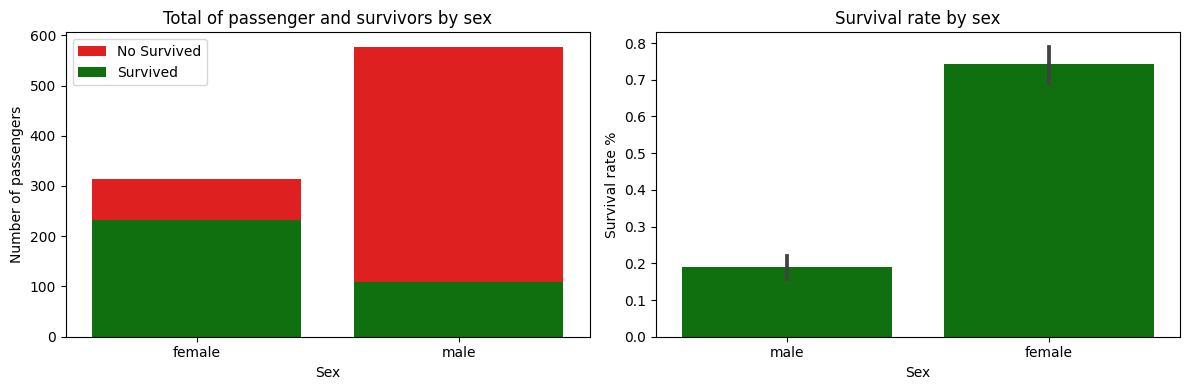

In [172]:
sex_stats = train_df.groupby('Sex')['Survived'].agg(total='count', survived='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=sex_stats.index, y=sex_stats['total'], color='red', label="No Survived", ax=axes[0])
sns.barplot(x=sex_stats.index, y=sex_stats['survived'], color='green', label="Survived", ax=axes[0])
axes[0].set_title('Total of passenger and survivors by sex')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='Sex', y='Survived', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Survival rate by sex')
axes[1].set_ylabel('Survival rate %')

plt.tight_layout()
plt.show()

### Total passengers and survivors by class and their proportion

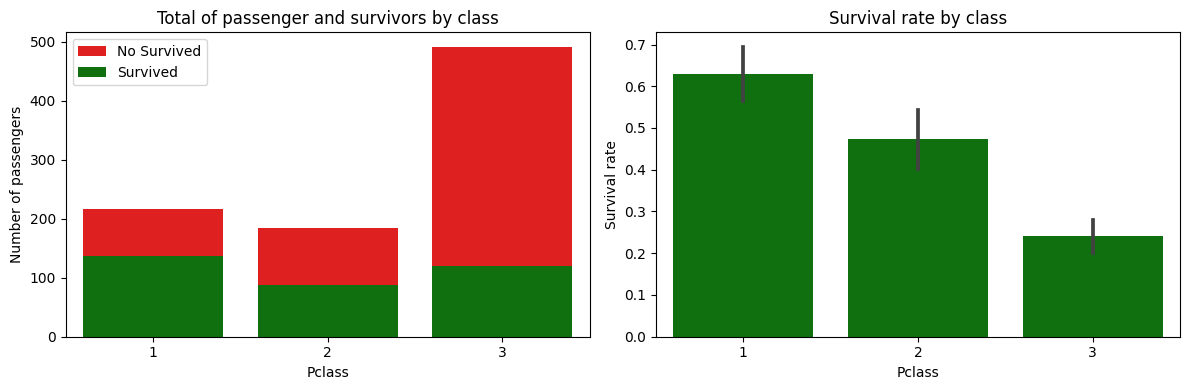

In [173]:
class_stats = train_df.groupby('Pclass')['Survived'].agg(total='count', survived='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=class_stats.index, y=class_stats['total'], color='red', label="No Survived", ax=axes[0])
sns.barplot(x=class_stats.index, y=class_stats['survived'], color='green', label="Survived", ax=axes[0])
axes[0].set_title('Total of passenger and survivors by class')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='Pclass', y='Survived', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Survival rate by class')
axes[1].set_ylabel('Survival rate')

plt.tight_layout()
plt.show()

### Total passengers and survivors by age and their proportion

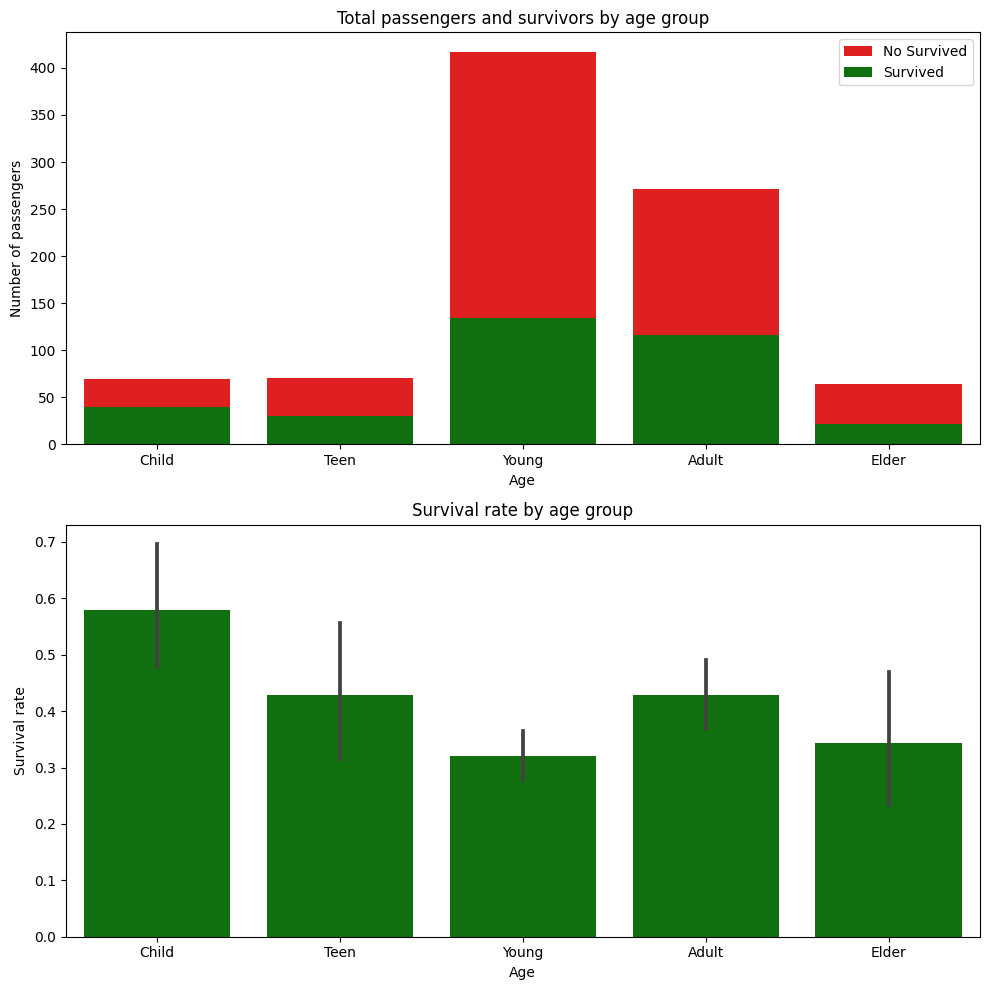

In [174]:
bins = [0, 12, 18, 30, 50, 80]
labels = ['Child','Teen','Young','Adult','Elder']
train_df['Age'] = pd.cut(train_df['Age'], bins=bins, labels=labels)
test_df['Age'] = pd.cut(test_df['Age'], bins=bins, labels=labels)

age_stats = train_df.groupby('Age')['Survived'].agg(total='count', survived='sum')

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.barplot(x=age_stats.index, y=age_stats['total'], color='red', label='No Survived', ax=axes[0])
sns.barplot(x=age_stats.index, y=age_stats['survived'], color='green', label='Survived', ax=axes[0])
axes[0].set_title('Total passengers and survivors by age group')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='Age', y='Survived', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Survival rate by age group')
axes[1].set_ylabel('Survival rate')

plt.tight_layout()
plt.show()

### Total passengers and survivors by fare and their proportion

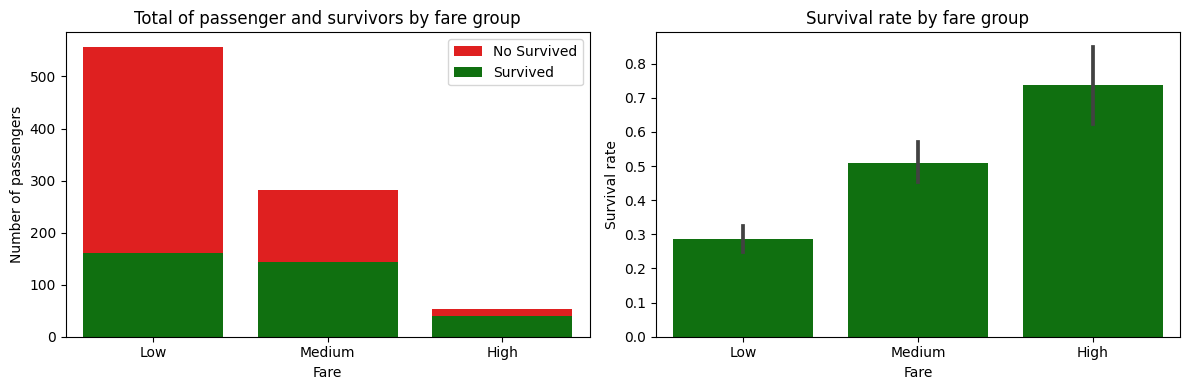

In [175]:
bins = [0, 25, 100, 1000]
labels = ['Low', 'Medium', 'High']
train_df['Fare'] = pd.cut(train_df['Fare'], bins=bins, labels=labels, include_lowest=True)
# train_df['Fare'] = pd.qcut(train_df['Fare'], q=5)
test_df['Fare'] = pd.cut(test_df['Fare'], bins=bins, labels=labels,include_lowest=True)

fare_stats = train_df.groupby('Fare')['Survived'].agg(total='count', survived='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=fare_stats.index, y=fare_stats['total'], color='red', label='No Survived', ax=axes[0])
sns.barplot(x=fare_stats.index, y=fare_stats['survived'], color='green', label='Survived', ax=axes[0])
axes[0].set_title('Total of passenger and survivors by fare group')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='Fare', y='Survived', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Survival rate by fare group')
axes[1].set_ylabel('Survival rate')

plt.tight_layout()
plt.show()

### Total passengers and survivors by embarked and their proportion

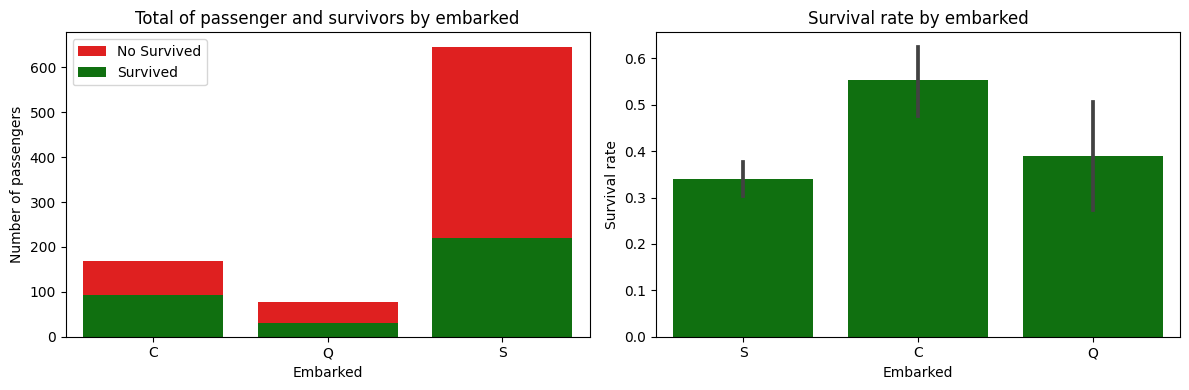

In [176]:
emb_stats = train_df.groupby('Embarked')['Survived'].agg(total='count', survived='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=emb_stats.index, y=emb_stats['total'], color='red', label='No Survived', ax=axes[0])
sns.barplot(x=emb_stats.index, y=emb_stats['survived'], color='green', label='Survived', ax=axes[0])
axes[0].set_title('Total of passenger and survivors by embarked')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='Embarked', y='Survived', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Survival rate by embarked')
axes[1].set_ylabel('Survival rate')

plt.tight_layout()
plt.show()

### Total passengers and survivors by family type and their proportion

In [177]:
# Making a new variable about the family size with the sum of SibSp and Parch
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

bins = [0, 1, 2, 4, 100]
labels = ['Alone', 'Couple', 'Normal family', 'Big family']

train_df['FamilyCategory'] = pd.cut(train_df['FamilySize'], bins=bins, labels=labels)
test_df['FamilyCategory'] = pd.cut(test_df['FamilySize'], bins=bins, labels=labels)

train_df = train_df.drop(columns=['FamilySize', 'SibSp','Parch'])
test_df = test_df.drop(columns=['FamilySize', 'SibSp','Parch'])

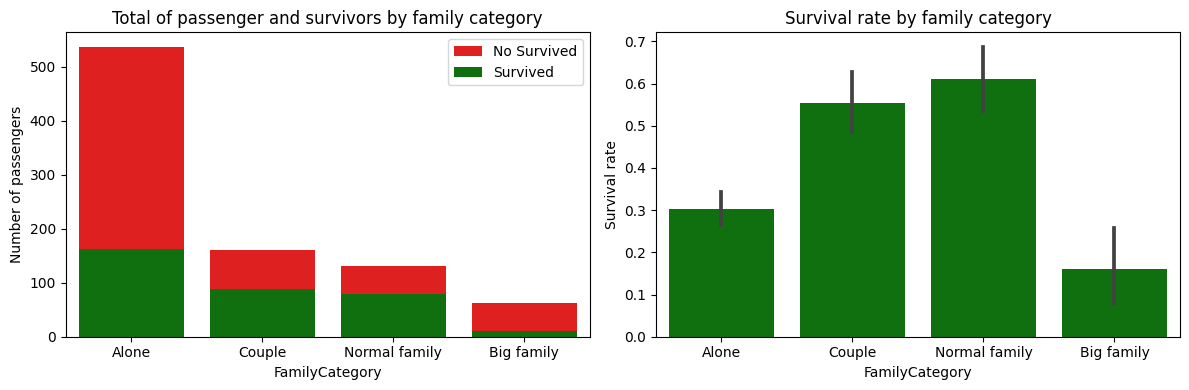

In [178]:
fam_stats = train_df.groupby('FamilyCategory')['Survived'].agg(total='count', survived='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=fam_stats.index, y=fam_stats['total'], color='red', label='No Survived', ax=axes[0])
sns.barplot(x=fam_stats.index, y=fam_stats['survived'], color='green', label='Survived', ax=axes[0])
axes[0].set_title('Total of passenger and survivors by family category')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='FamilyCategory', y='Survived', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Survival rate by family category')
axes[1].set_ylabel('Survival rate')

plt.tight_layout()
plt.show()

### Total passengers and survivors by class and age and their proportion

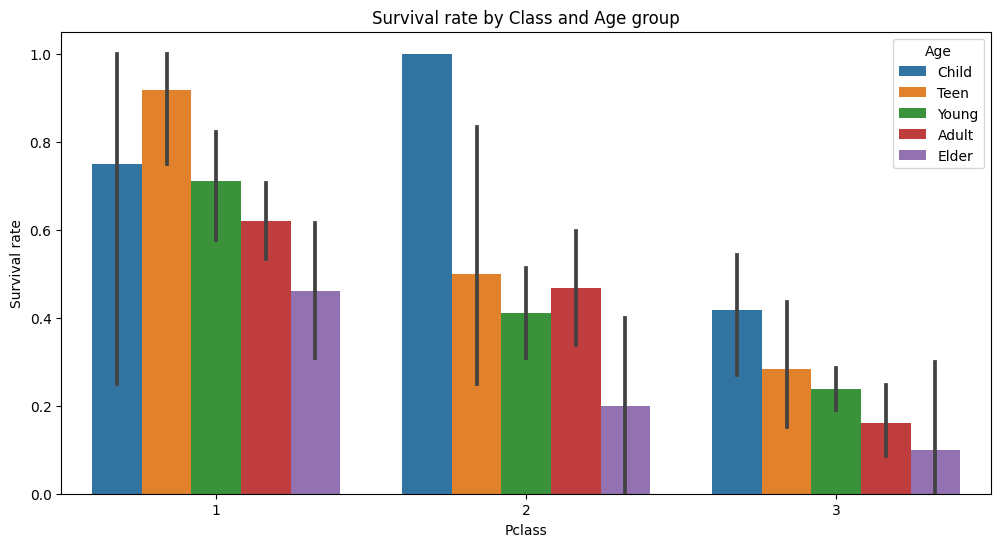

In [179]:
plt.figure(figsize=(12,6))
sns.barplot(x='Pclass', y='Survived', hue='Age', data=train_df)
plt.title('Survival rate by Class and Age group')
plt.ylabel('Survival rate')
plt.show()

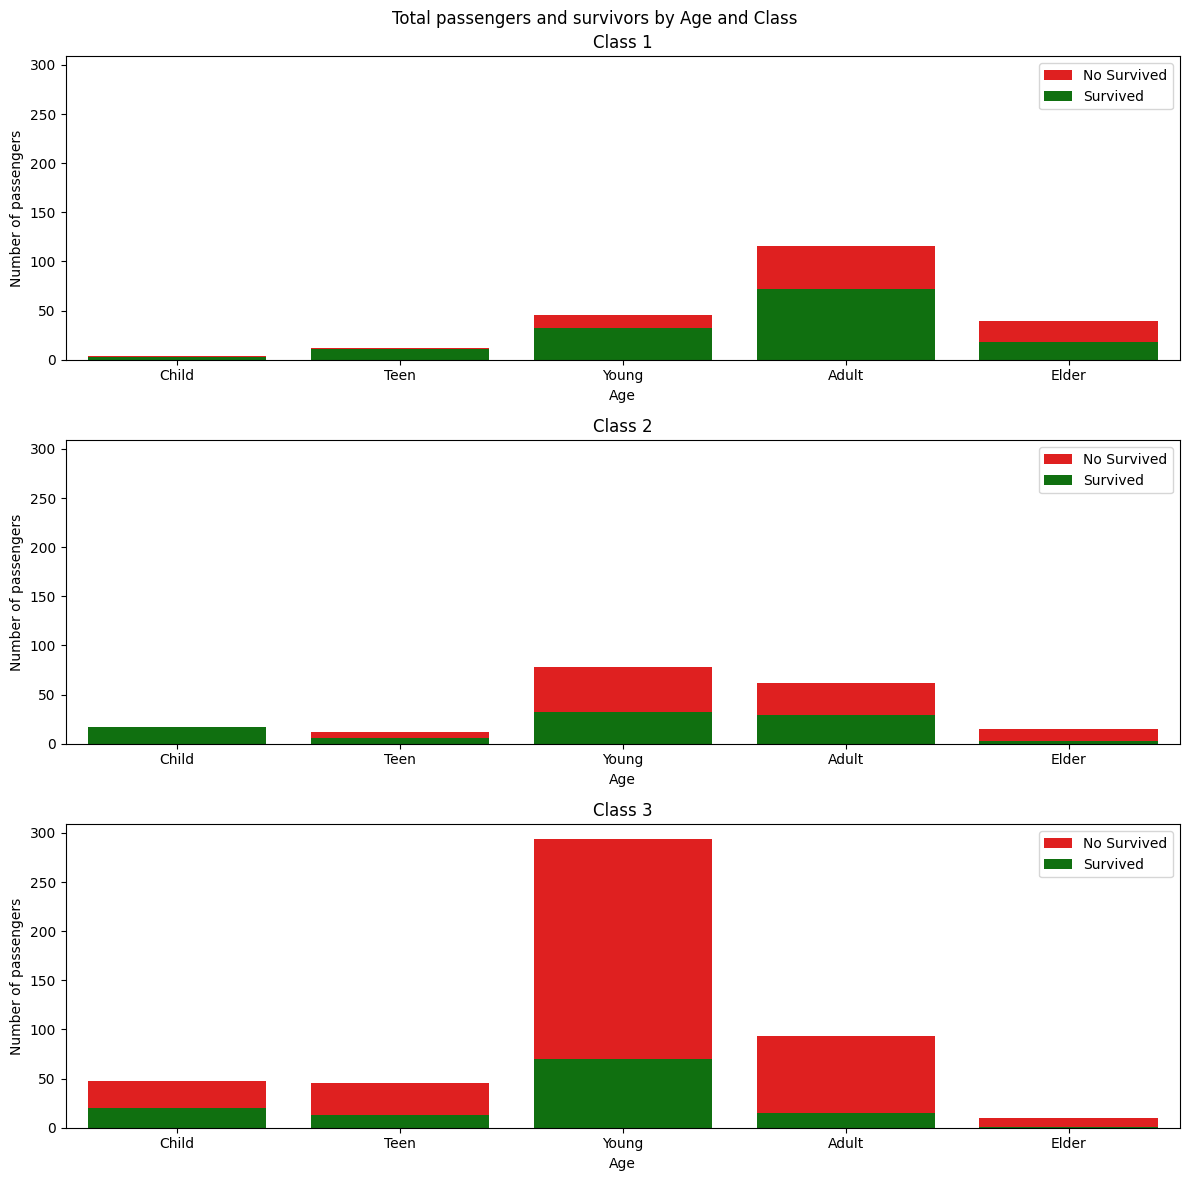

In [180]:
age_class_stats = train_df.groupby(['Pclass','Age'])['Survived'].agg(total='count', survived='sum').unstack()
fig, axes = plt.subplots(3, 1, figsize=(12,12), sharey=True)

for i, cls in enumerate(age_class_stats.index):
    ax = axes[i]
    survived = age_class_stats.loc[cls]['survived']
    total = age_class_stats.loc[cls]['total']
    
    sns.barplot(x=total.index, y=total, color='red', label="No Survived", ax=ax)
    sns.barplot(x=total.index, y=survived, color='green', label="Survived", ax=ax)
    ax.set_title(f'Class {cls}')
    ax.set_ylabel('Number of passengers')
    ax.legend()

fig.suptitle('Total passengers and survivors by Age and Class')

plt.tight_layout()
plt.show()

### Total passengers and survivors by sex and age and their proportion

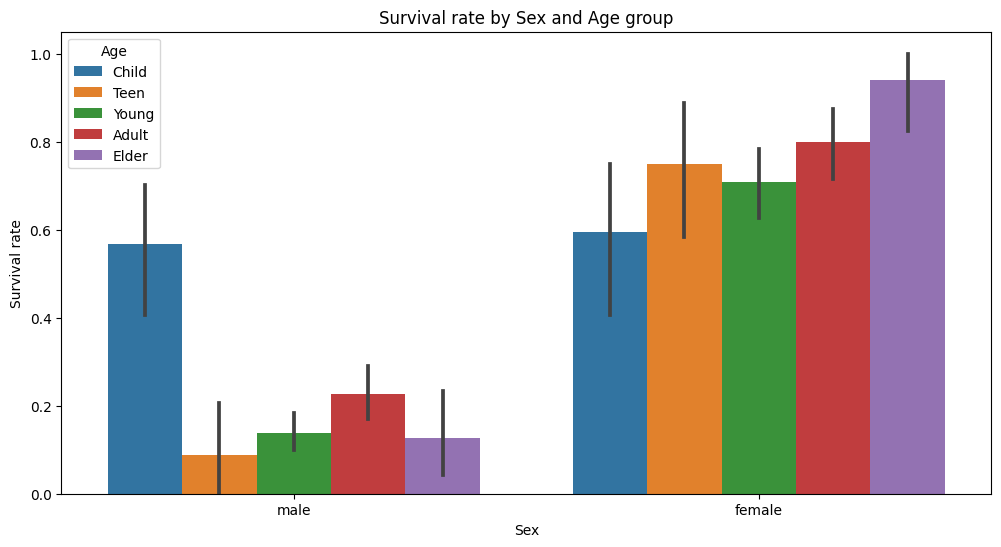

In [181]:
plt.figure(figsize=(12,6))
sns.barplot(x='Sex', y='Survived', hue='Age', data=train_df)
plt.title('Survival rate by Sex and Age group')
plt.ylabel('Survival rate')
plt.show()

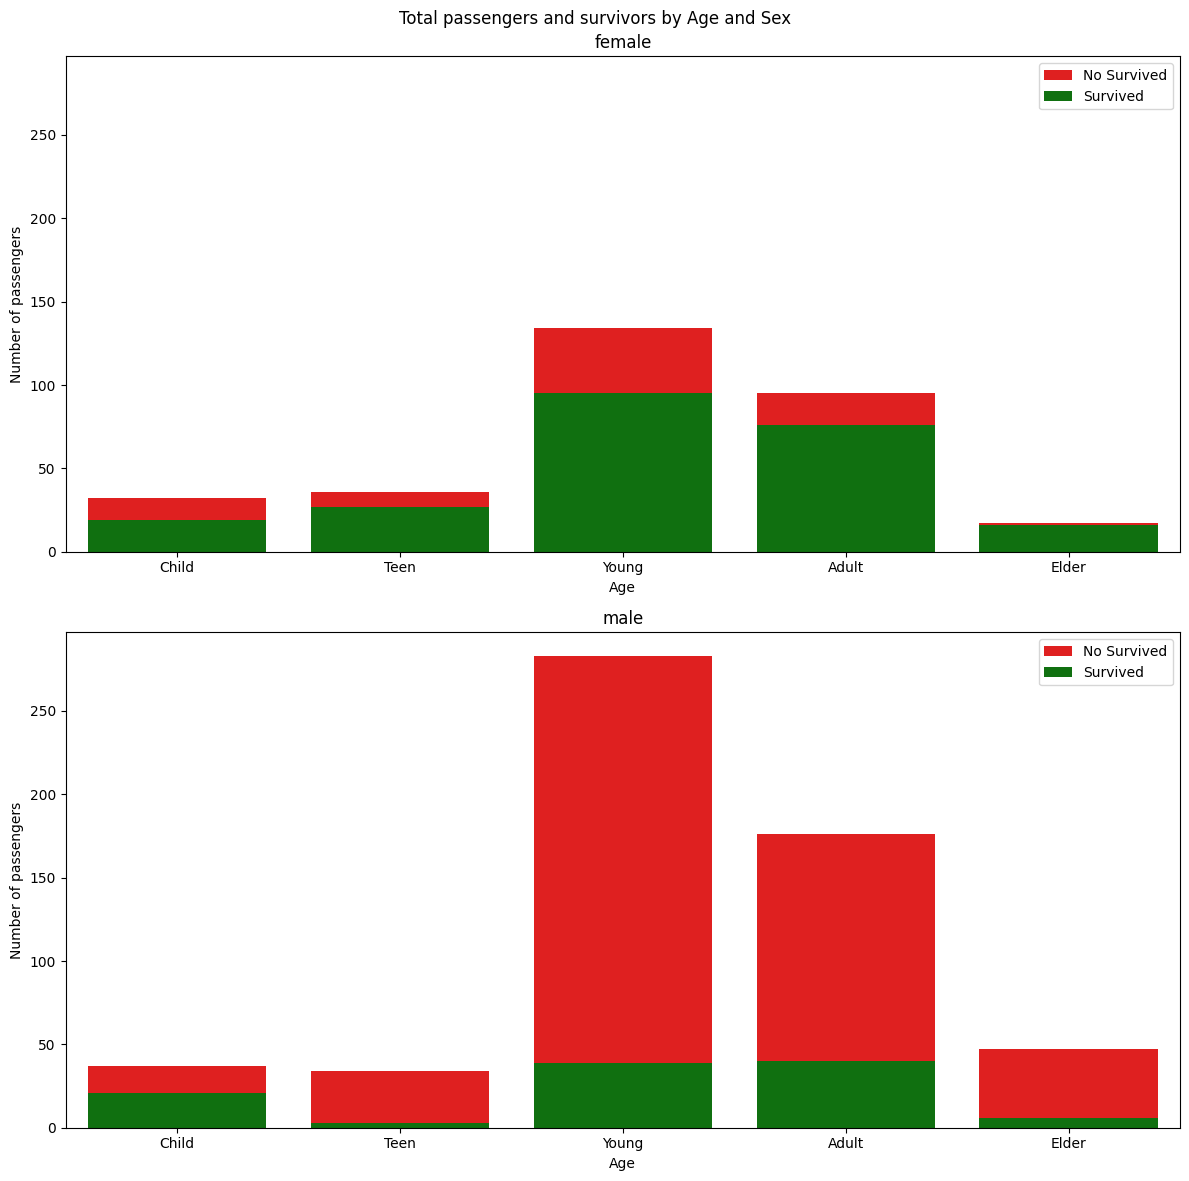

In [182]:
age_sex_stats = train_df.groupby(['Sex','Age'])['Survived'].agg(total='count', survived='sum').unstack()
fig, axes = plt.subplots(2, 1, figsize=(12,12), sharey=True)

for i, sex in enumerate(age_sex_stats.index):
    ax = axes[i]
    survived = age_sex_stats.loc[sex]['survived']
    total = age_sex_stats.loc[sex]['total']
    
    sns.barplot(x=total.index, y=total, color='red', label="No Survived", ax=ax)
    sns.barplot(x=total.index, y=survived, color='green', label="Survived", ax=ax)
    ax.set_title(sex)
    ax.set_ylabel('Number of passengers')
    ax.legend()

fig.suptitle('Total passengers and survivors by Age and Sex')

plt.tight_layout()
plt.show()

### Total passengers and survivors by class and sex and their proportion

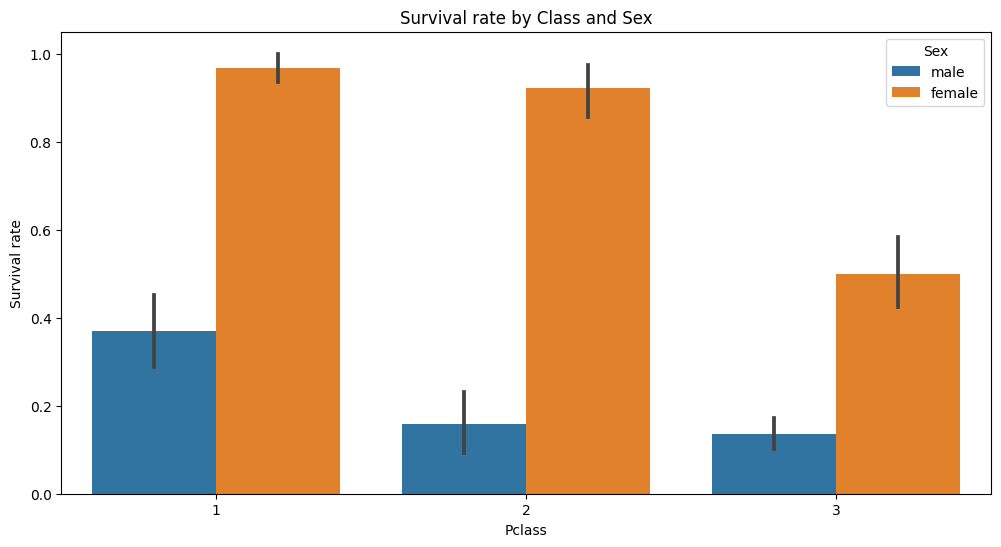

In [183]:
plt.figure(figsize=(12,6))
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train_df)
plt.title('Survival rate by Class and Sex')
plt.ylabel('Survival rate')
plt.show()

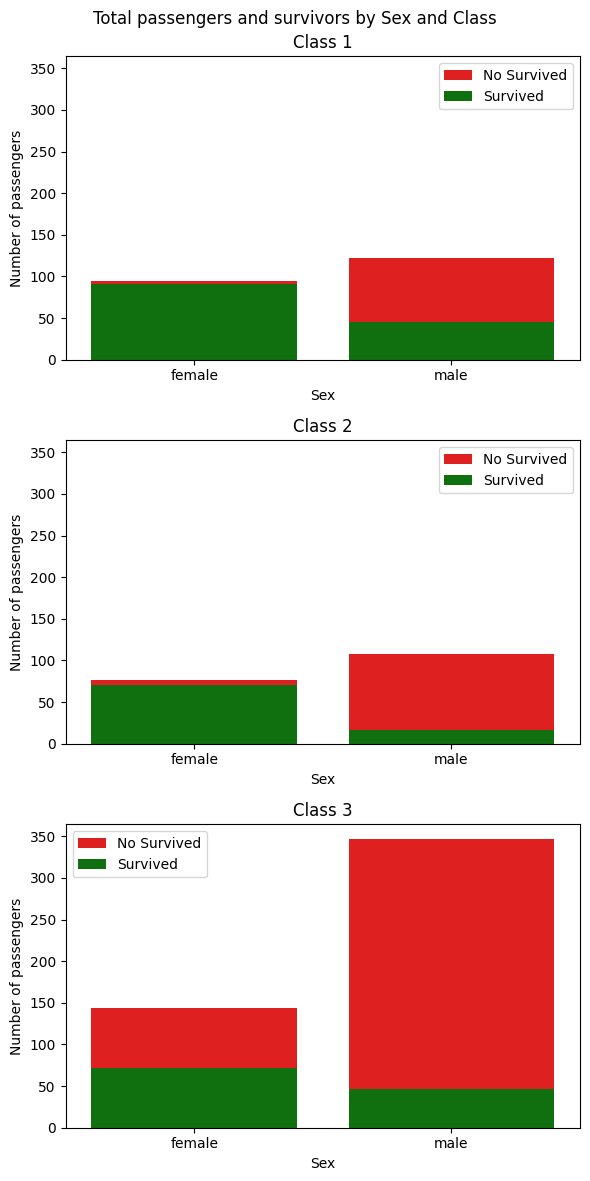

In [184]:
sex_class_stats = train_df.groupby(['Pclass','Sex'])['Survived'].agg(total='count', survived='sum').unstack()
fig, axes = plt.subplots(3, 1, figsize=(6,12), sharey=True)

for i, cls in enumerate(sex_class_stats.index):
    ax = axes[i]
    survived = sex_class_stats.loc[cls]['survived']
    total = sex_class_stats.loc[cls]['total']
    
    sns.barplot(x=total.index, y=total, color='red', label="No Survived", ax=ax)
    sns.barplot(x=total.index, y=survived, color='green', label="Survived", ax=ax)
    ax.set_title(f'Class {cls}')
    ax.set_ylabel('Number of passengers')
    ax.legend()

fig.suptitle('Total passengers and survivors by Sex and Class')

plt.tight_layout()
plt.show()

### Data cleaning and study of correlations

In [185]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Survived        891 non-null    int64   
 1   Pclass          891 non-null    int64   
 2   Sex             891 non-null    object  
 3   Age             891 non-null    category
 4   Fare            891 non-null    category
 5   Embarked        891 non-null    object  
 6   FamilyCategory  891 non-null    category
dtypes: category(3), int64(2), object(2)
memory usage: 31.1+ KB


In [186]:
category_mappings = {}

categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')
    
    # Saving the int value for each category in a map
    category_mappings[col] = dict(enumerate(train_df[col].cat.categories))
    
    # Categorical to int
    train_df[col] = train_df[col].cat.codes
    test_df[col] = test_df[col].cat.codes

print("\n=== Mappings guardados ===")
print(category_mappings)


=== Mappings guardados ===
{'Sex': {0: 'female', 1: 'male'}, 'Age': {0: 'Child', 1: 'Teen', 2: 'Young', 3: 'Adult', 4: 'Elder'}, 'Fare': {0: 'Low', 1: 'Medium', 2: 'High'}, 'Embarked': {0: 'C', 1: 'Q', 2: 'S'}, 'FamilyCategory': {0: 'Alone', 1: 'Couple', 2: 'Normal family', 3: 'Big family'}}


In [187]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Survived        891 non-null    int64
 1   Pclass          891 non-null    int64
 2   Sex             891 non-null    int8 
 3   Age             891 non-null    int8 
 4   Fare            891 non-null    int8 
 5   Embarked        891 non-null    int8 
 6   FamilyCategory  891 non-null    int8 
dtypes: int64(2), int8(5)
memory usage: 18.4 KB


In [188]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilyCategory
0,0,3,1,2,0,2,1
1,1,1,0,3,1,0,1
2,1,3,0,2,0,2,0
3,1,1,0,3,1,2,1
4,0,3,1,3,0,2,0


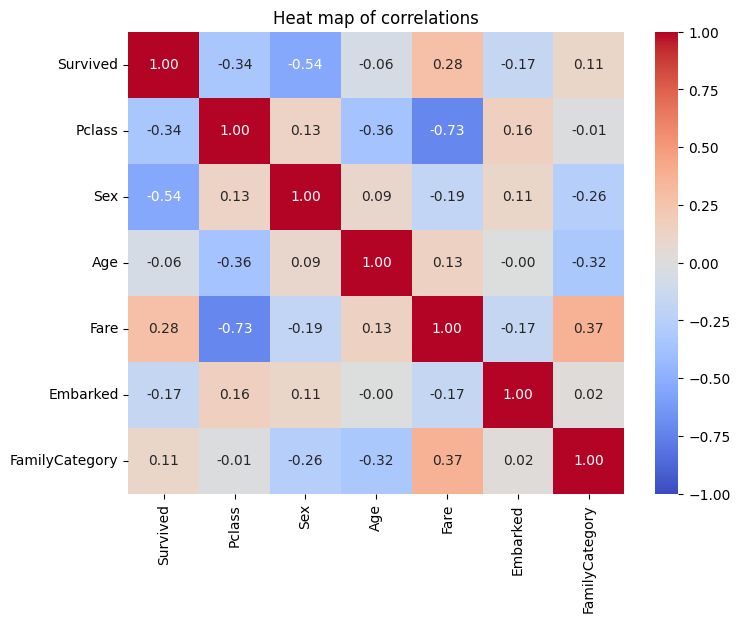

In [189]:
corr_matrix = train_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Heat map of correlations")
plt.show()

# Predictive models

In [190]:
train_clean_df = train_df.copy()
test_clean_df = test_df.copy()

train_clean_df = train_clean_df.drop(columns=['Fare', 'Embarked'])
test_clean_df = test_clean_df.drop(columns=['Fare', 'Embarked'])

In [191]:
train_clean_df.info()
train_clean_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Survived        891 non-null    int64
 1   Pclass          891 non-null    int64
 2   Sex             891 non-null    int8 
 3   Age             891 non-null    int8 
 4   FamilyCategory  891 non-null    int8 
dtypes: int64(2), int8(3)
memory usage: 16.7 KB


,Survived,Pclass,Sex,Age,FamilyCategory
0,0,3,1,2,1
1,1,1,0,3,1
2,1,3,0,2,0
3,1,1,0,3,1
4,0,3,1,3,0


In [192]:
X_train = train_clean_df.drop("Survived", axis=1)
Y_train = train_clean_df["Survived"]
X_test  = test_clean_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 4), (891,), (418, 4))

In [193]:
models_df = pd.DataFrame(columns=['Model', 'Accuracy_Mean', 'Accuracy_Std'])

## Logistic Regression

In [194]:
# Standarization + Logistic Regression

log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(penalty='l2', C=10, solver='lbfgs', max_iter=1000, tol=1e-3))])

scores = cross_val_score(log_reg_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['Logistic Regression', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8036 ± 0.0078


In [195]:
log_reg_pipeline.fit(X_train, Y_train)
coeff_df = pd.DataFrame(train_clean_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(log_reg_pipeline.named_steps['log_reg'].coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
3,FamilyCategory,-0.232836
2,Age,-0.489432
0,Pclass,-1.007858
1,Sex,-1.299392


## Naive Bayes

In [196]:
# Naive Bayes

nb_model = GaussianNB()

scores = cross_val_score(nb_model, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['Naive Bayes', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.7811 ± 0.0143


## Perceptron

In [197]:
# Standarization + Perceptron

perceptron_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('perceptron', Perceptron(max_iter=1000, tol=1e-3))])

scores = cross_val_score(perceptron_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['Perceptron', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.7532 ± 0.0327


## SGD

In [198]:
# Standarization + SGD

sgd_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier(loss='log_loss', penalty='l2', alpha=0.01, 
                          max_iter=1000, tol=1e-3))])

scores = cross_val_score(sgd_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['SGD', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8002 ± 0.0104


## SVM

In [199]:
# Standarization + SVM

svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=1, kernel='rbf', gamma='scale', max_iter=1000, tol=1e-3,
               probability=True))])

scores = cross_val_score(svc_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['SVM', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8316 ± 0.0212


## Linear SVM

In [200]:
# Standarization + Linear SVM

linear_svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC(C=1, penalty='l2', loss='squared_hinge', 
                      max_iter=1000, tol=1e-3))])

scores = cross_val_score(linear_svc_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['Linear SVM', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.7968 ± 0.0158


## KNN

In [201]:
# Standarization + KNN

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=10, weights='distance', 
                                 metric='minkowski', p=2))])

scores = cross_val_score(knn_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['KNN', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8193 ± 0.0185


## Decision Tree

In [202]:
# Decision Tree

tree_model = DecisionTreeClassifier(criterion='gini', max_depth=6, 
                                    min_samples_split=2, min_samples_leaf=1)

scores = cross_val_score(tree_model, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['Decision Tree', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8227 ± 0.0127


## Random Forest

In [203]:
# Random Forest

rf_model = RandomForestClassifier(n_estimators=250, criterion='gini', max_depth=4, n_jobs=-1,
                                  min_samples_split=2, min_samples_leaf=1, max_features='sqrt')

scores = cross_val_score(rf_model, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['Random Forest', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8305 ± 0.0188


## Gradient Boosting

In [204]:
# Gradient Boosting

gb_model = GradientBoostingClassifier(n_estimators=250, learning_rate=0.1, max_depth=4, 
                                      min_samples_split=2, min_samples_leaf=1, subsample=1)

scores = cross_val_score(gb_model, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['Gradient Boosting', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8227 ± 0.0145


## XGBoost

In [205]:
# XGBoost

xgb_model = xgb.XGBClassifier(n_estimators=250, learning_rate=0.1, max_depth=4, 
                              subsample=1, colsample_bytree=1, objective='binary:logistic',  
                              use_label_encoder=False, eval_metric='logloss')

scores = cross_val_score(xgb_model, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['XGBoost', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8249 ± 0.0148


## LightGBM

In [206]:
# LightGBM

lgb_model = lgb.LGBMClassifier(n_estimators=250, learning_rate=0.1, max_depth=4, num_leaves=7,
                               subsample=1, bagging_fraction=1, feature_fraction=1, bagging_freq=1, 
                               objective='binary', metric='binary_logloss', boosting_type='gbdt',
                               verbose=-1)

scores = cross_val_score(lgb_model, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['LightGBM', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8227 ± 0.0145


## MLP

In [207]:
# Standarization + MLP

mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(50,20), activation='relu', solver='adam', 
                          learning_rate_init=0.001, max_iter=1000, tol=1e-4))])

scores = cross_val_score(mlp_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['MLP', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8227 ± 0.0127


### Model accuracy analysis

In [208]:
models_df.sort_values(by='Accuracy_Mean', ascending=False)

,Model,Accuracy_Mean,Accuracy_Std
4,SVM,0.831624,0.021197
8,Random Forest,0.830507,0.018765
10,XGBoost,0.824914,0.014841
7,Decision Tree,0.822666,0.012670
9,Gradient Boosting,0.822666,0.014527
11,LightGBM,0.822666,0.014527
12,MLP,0.822666,0.012670
6,KNN,0.819315,0.018487
0,Logistic Regression,0.803597,0.007797
3,SGD,0.800226,0.010381


## Stacking

In [209]:
# Stacking

# Base Models - RF, SVM, XGBoost

estimators = [('rf', rf_model),
             ('svm', svc_pipeline),
             ('xgb', xgb_model)]

# Meta-Learner

meta_learner = LogisticRegression()

stack_model = StackingClassifier(estimators=estimators, final_estimator=meta_learner,
                                 cv=5, n_jobs=-1, passthrough=False, stack_method='predict_proba')

scores = cross_val_score(stack_model, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['Stacking', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8327 ± 0.0225


In [210]:
models_df.sort_values(by='Accuracy_Mean', ascending=False)

,Model,Accuracy_Mean,Accuracy_Std
13,Stacking,0.832741,0.022494
4,SVM,0.831624,0.021197
8,Random Forest,0.830507,0.018765
10,XGBoost,0.824914,0.014841
7,Decision Tree,0.822666,0.012670
9,Gradient Boosting,0.822666,0.014527
11,LightGBM,0.822666,0.014527
12,MLP,0.822666,0.012670
6,KNN,0.819315,0.018487
0,Logistic Regression,0.803597,0.007797


## Training and submission of the best models

In [211]:
stack_model.fit(X_train, Y_train)

y_test_pred = stack_model.predict(X_test)

submission_stack = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_test_pred})

submission_stack.to_csv('submission_stack.csv', index=False)

In [212]:
rf_model.fit(X_train, Y_train)

y_test_pred = rf_model.predict(X_test)

submission_rf = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_test_pred})

submission_rf.to_csv('submission_rf.csv', index=False)

In [213]:
svc_pipeline.fit(X_train, Y_train)

y_test_pred = svc_pipeline.predict(X_test)

submission_svc = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_test_pred})

submission_svc.to_csv('submission_svc.csv', index=False)

In [214]:
xgb_model.fit(X_train, Y_train)

y_test_pred = xgb_model.predict(X_test)

submission_xgb = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_test_pred})

submission_xgb.to_csv('submission_xgb.csv', index=False)